In [1]:
#テキストファイルでパイナップルの(頂点+色)を取得
#maisuごとにDCT、IDCTする
#32bit演算
#YCbCrでPSNR計算してる→ひとまずYCbCrでやる

#新しい量子化テーブルでのDCT量子化後の数値を16進数にしてTeratermで送信する

In [4]:
import numpy as np
#量子化テーブルシフト版
ryoshi_shift = np.array([[128,  16,  16,  16,  16,  32,  32,  64 ],
                        [ 16,  16,  16,  16,  32,  64,  64,  64 ],
                        [ 16,  16,  16,  32,  32,  64,  64,  64 ],
                        [ 16,  16,  22,  32,  64,  64,  64,  64 ],
                        [ 16,  32,  32,  64,  64, 128, 128,  128 ],
                        [ 32,  32,  64,  64,  81, 128, 128,  128 ],
                        [ 64,  64,  64,  128, 128, 128, 128, 128 ],
                        [ 64,  128,  128,  128, 128, 128, 128, 128 ]])

ryoshi_shift = ryoshi_shift*2
print(ryoshi_shift)

[[256  32  32  32  32  64  64 128]
 [ 32  32  32  32  64 128 128 128]
 [ 32  32  32  64  64 128 128 128]
 [ 32  32  44  64 128 128 128 128]
 [ 32  64  64 128 128 256 256 256]
 [ 64  64 128 128 162 256 256 256]
 [128 128 128 256 256 256 256 256]
 [128 256 256 256 256 256 256 256]]


In [1]:
#量子化テーブルの作成
import numpy as np

bairituY = 2
bairituC = 0.75
dc = 20

tableY = np.zeros((8,8))
ryoshi_Y = np.array([[80,  11,  10,  16,  24,  40,  51,  61 ],
[ 12,  12,  14,  19,  26,  58,  60,  55 ],
[ 14,  13,  16,  24,  40,  57,  69,  56 ],
[ 14,  17,  22,  29,  51,  87,  80,  62 ],
[ 18,  22,  37,  56,  68, 109, 103,  77 ],
[ 24,  35,  55,  64,  81, 104, 113,  92 ],
[ 49,  64,  78,  87, 103, 121, 120, 101 ],
[ 72,  92,  95,  98, 112, 100, 103,  99 ]])

tableY = (ryoshi_Y*bairituY).astype(np.int32)
tableY[tableY < 1] = 1
print(tableY)

tableC = np.zeros((8,8))
ryoshi_C = np.array([[dc*8,  18,  24,  47,  99,  99,  99 , 99 ],
[ 18,  21,  26,  66,  99,  99,  99,  99 ],
[ 24,  26,  56,  99,  99,  99,  99,  99 ],
[ 47,  66,  99,  99,  99,  99,  99,  99 ],
[ 99,  99,  99,  99,  99,  99,  99,  99 ],
[ 99,  99,  99,  99,  99,  99,  99,  99 ],
[ 99,  99,  99,  99,  99,  99,  99,  99 ],
[ 99,  99,  99,  99,  99,  99,  99,  99 ]])


tableC = (ryoshi_C*bairituC).astype(np.int32)
tableC[tableC<1] =1
print(tableC)

[[160  22  20  32  48  80 102 122]
 [ 24  24  28  38  52 116 120 110]
 [ 28  26  32  48  80 114 138 112]
 [ 28  34  44  58 102 174 160 124]
 [ 36  44  74 112 136 218 206 154]
 [ 48  70 110 128 162 208 226 184]
 [ 98 128 156 174 206 242 240 202]
 [144 184 190 196 224 200 206 198]]
[[120  13  18  35  74  74  74  74]
 [ 13  15  19  49  74  74  74  74]
 [ 18  19  42  74  74  74  74  74]
 [ 35  49  74  74  74  74  74  74]
 [ 74  74  74  74  74  74  74  74]
 [ 74  74  74  74  74  74  74  74]
 [ 74  74  74  74  74  74  74  74]
 [ 74  74  74  74  74  74  74  74]]


In [7]:
#DCT
import numpy as np

def proposed_stage_1(x):
    X = np.zeros((8,))
    X[0] = x[0] + x[7]
    X[1] = x[1] + x[6]
    X[2] = x[2] + x[5]
    X[3] = x[3] + x[4]
    X[4] = x[3] - x[4]
    X[5] = x[2] - x[5]
    X[6] = x[1] - x[6]
    X[7] = x[0] - x[7]
    return X

def proposed_stage_2(x):
    X = np.copy(x)
    X[0] = x[0] + x[3]
    X[1] = x[1] + x[2]
    X[2] = x[1] - x[2]
    X[3] = x[0] - x[3]
    return X

def proposed_stage_3(x):
    X = np.copy(x)
    X[0] = x[0] + x[1]
    X[4] = x[0] - x[1]
    X[6] = -x[2]
    X[2] = x[3]
    X[5] = x[4]
    X[7] = x[5]
    X[1] = x[6]
    X[3] = x[7]
    return X

def proposed_stage_1_inverse(X):
    x = np.zeros((8,))
    x[0] = 0.5 * (X[0] + X[7])
    x[1] = 0.5 * (X[1] + X[6])
    x[2] = 0.5 * (X[2] + X[5])
    x[3] = 0.5 * (X[3] + X[4])
    x[4] = 0.5 * (X[3] - X[4])
    x[5] = 0.5 * (X[2] - X[5])
    x[6] = 0.5 * (X[1] - X[6])
    x[7] = 0.5 * (X[0] - X[7])
    return x

def proposed_stage_2_inverse(X):
    x = np.copy(X)
    x[0] = 0.5 * (X[0] + X[3])
    x[1] = 0.5 * (X[1] + X[2])
    x[2] = 0.5 * (X[1] - X[2])
    x[3] = 0.5 * (X[0] - X[3])
    return x

def proposed_stage_3_inverse(X):
    x = np.copy(X)
    x[0] = 0.5 * (X[0] + X[4])
    x[1] = 0.5 * (X[0] - X[4])
    x[2] = -X[6]
    x[3] = X[2]
    x[4] = X[5]
    x[5] = X[7]
    x[6] = X[1]
    x[7] = X[3]
    return x

def DCT1(x):
    X_1 = proposed_stage_1(x)
    X_2 = proposed_stage_2(X_1)
    X_3 = proposed_stage_3(X_2)
    return X_3

def IDCT1(X_3):
    X_2 = proposed_stage_3_inverse(X_3)
    X_1 = proposed_stage_2_inverse(X_2)
    x = proposed_stage_1_inverse(X_1)
    return x

def tenchi2D(x):
    x = np.transpose(x)
    return x

def DCT_2D(x):
    X_out1 = np.zeros((8,8))
    X_out2 = np.zeros((8,8))
    for i in range(8):
        X_out1[i] = DCT1(x[i])
    #print(X_out1.astype(np.int16))
    X_out1 = tenchi2D(X_out1)
    for i in range(8):
        X_out2[i] = DCT1(X_out1[i])
    return X_out2
    
def IDCT_2D(X_out2):
    X_out1 = np.zeros((8,8))
    x = np.zeros((8,8))
    for i in range(8):
        X_out1[i] = IDCT1(X_out2[i])
    #転置
    X_out1 = tenchi2D(X_out1)
    # ｘ方向
    for i in range(8):
        x[i] = IDCT1(X_out1[i])
    return x

In [90]:
#ryoshi
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd



#a = np.ones((8,8))*100
img = cv2.imread('slime88.bmp')
b = img[:,:,0].astype(np.int16)
g = img[:,:,1].astype(np.int16)
r = img[:,:,2].astype(np.int16)
print(g)
print(r)
print(b)


G = DCT_2D(g)
R = DCT_2D(r)
B = DCT_2D(b)

# print(G.astype(np.int16))
# print(R.astype(np.int16))
# print(B.astype(np.int16))

G = G/ryoshi_shift
R = R/ryoshi_shift
B = B/ryoshi_shift

G_ryoshi = G.astype(np.int16)
R_ryoshi = R.astype(np.int16)
B_ryoshi = B.astype(np.int16)

print(G_ryoshi)
print(R_ryoshi)
print(B_ryoshi)

G = G_ryoshi*ryoshi_shift
R = R_ryoshi*ryoshi_shift
B = B_ryoshi*ryoshi_shift

print(G.astype(np.int16))
print(R.astype(np.int16))
print(B.astype(np.int16))

g = IDCT_2D(G)
r = IDCT_2D(R)
b = IDCT_2D(B)

print(g)
print(r)
print(b)

img_fukugen = np.zeros((8,8,3))
img_fukugen[:,:,0] = b
img_fukugen[:,:,1] = g
img_fukugen[:,:,2] = r

cv2.imwrite("slime88_fukugen.bmp", img_fukugen)


[[255 255 255 255 255 255 255 255]
 [255 255 255 151 155 255 255 255]
 [255 255 252 150 150 253 255 255]
 [255 150 150 150 150 150 150 255]
 [150 150 150 255 255 150 150 150]
 [150 150 150 254 253 150 150 150]
 [255 150 150  22  22 150 150 255]
 [255 255 229 150 150 207 255 255]]
[[255 255 255 255 255 255 255 255]
 [255 255 255   5   4 255 255 255]
 [255 255 255  11  11 255 255 255]
 [255  11  11  11  11  11  11 255]
 [ 11  11  11 255 255  11  11  11]
 [ 11  11  11 254 253  11  11  11]
 [255  11  11 188 188  11  11 255]
 [255 255 229  11  11 207 255 255]]
[[255 255 255 255 255 255 255 255]
 [255 255 255 198 198 255 255 255]
 [255 255 248 207 207 248 255 255]
 [255 207 207 207 207 207 207 255]
 [207 207 207 255 255 207 207 207]
 [207 207 207 254 251 207 207 207]
 [255 207 207  60  60 207 207 255]
 [255 255 229 207 207 207 255 255]]
[[50 21 30  8 12  0  3  3]
 [ 0  0  0  0  0  0  0  0]
 [27 -8  6 -3 -7  3 -5  3]
 [ 0  0  0  0  0  0  0  0]
 [ 1 -2 -8  1  4  0  0 -1]
 [ 0  0  0  0  0  0  0

True

In [22]:
#notShift
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd



#a = np.ones((8,8))*100
img = cv2.imread('slime88.bmp')
b = img[:,:,0].astype(np.int16)
g = img[:,:,1].astype(np.int16)
r = img[:,:,2].astype(np.int16)
print(g)
print(r)
print(b)


G = DCT_2D(g)
R = DCT_2D(r)
B = DCT_2D(b)

# print(G.astype(np.int16))
# print(R.astype(np.int16))
# print(B.astype(np.int16))

G = G/tableY
R = R/tableY
B = B/tableY

G_ryoshi = G.astype(np.int16)
R_ryoshi = R.astype(np.int16)
B_ryoshi = B.astype(np.int16)

print(G_ryoshi)
print(R_ryoshi)
print(B_ryoshi)

G = G_ryoshi*tableY
R = R_ryoshi*tableY
B = B_ryoshi*tableY

print(G.astype(np.int16))
print(R.astype(np.int16))
print(B.astype(np.int16))

g = IDCT_2D(G)
r = IDCT_2D(R)
b = IDCT_2D(B)

print(g.astype(np.int16))
print(r.astype(np.int16))
print(b.astype(np.int16))

img_fukugen = np.zeros((8,8,3))
img_fukugen[:,:,0] = b
img_fukugen[:,:,1] = g
img_fukugen[:,:,2] = r

cv2.imwrite("slime88_fukugen.bmp", img_fukugen)


[[255 255 255 255 255 255 255 255]
 [255 255 255 151 155 255 255 255]
 [255 255 252 150 150 253 255 255]
 [255 150 150 150 150 150 150 255]
 [150 150 150 255 255 150 150 150]
 [150 150 150 254 253 150 150 150]
 [255 150 150  22  22 150 150 255]
 [255 255 229 150 150 207 255 255]]
[[255 255 255 255 255 255 255 255]
 [255 255 255   5   4 255 255 255]
 [255 255 255  11  11 255 255 255]
 [255  11  11  11  11  11  11 255]
 [ 11  11  11 255 255  11  11  11]
 [ 11  11  11 254 253  11  11  11]
 [255  11  11 188 188  11  11 255]
 [255 255 229  11  11 207 255 255]]
[[255 255 255 255 255 255 255 255]
 [255 255 255 198 198 255 255 255]
 [255 255 248 207 207 248 255 255]
 [255 207 207 207 207 207 207 255]
 [207 207 207 255 255 207 207 207]
 [207 207 207 254 251 207 207 207]
 [255 207 207  60  60 207 207 255]
 [255 255 229 207 207 207 255 255]]
[[ 80  31  48   8   8   0   2   3]
 [  0   0   0   0   0   0   0   0]
 [ 31 -10   6  -4  -5   3  -4   3]
 [  0   0   0   0   0   0   0   0]
 [  1  -3  -7   1

True

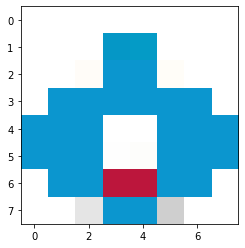

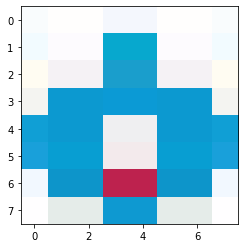

In [20]:
img = cv2.imread("slime88.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

img2 = cv2.imread("slime88_fukugen.bmp")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

In [21]:
import numpy as np

# -128から127の範囲でランダムな整数の数列を生成
#array_8x8 = np.random.randint(-128, 128, size=(8, 8), dtype=np.int8)

# 各値を8ビットのバイナリ表示に変換して16進数表示に変換
binary_array_8x8 = np.vectorize(lambda x: format(x & 0xFF, '08b'))(G_ryoshi)
hex_array_8x8 = np.vectorize(lambda x: format(int(x, 2), '02X'))(binary_array_8x8)

# 16進数表示の数列を元のサイズで表示
print(hex_array_8x8)

# 各値を8ビットのバイナリ表示に変換して16進数表示に変換
binary_array_8x8 = np.vectorize(lambda x: format(x & 0xFF, '08b'))(R_ryoshi)
hex_array_8x8 = np.vectorize(lambda x: format(int(x, 2), '02X'))(binary_array_8x8)

# 16進数表示の数列を元のサイズで表示
print(hex_array_8x8)

# 各値を8ビットのバイナリ表示に変換して16進数表示に変換
binary_array_8x8 = np.vectorize(lambda x: format(x & 0xFF, '08b'))(B_ryoshi)
hex_array_8x8 = np.vectorize(lambda x: format(int(x, 2), '02X'))(binary_array_8x8)

# 16進数表示の数列を元のサイズで表示
print(hex_array_8x8)



[['50' '1F' '30' '08' '08' '00' '02' '03']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['1F' 'F6' '06' 'FC' 'FB' '03' 'FC' '03']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['01' 'FD' 'F9' '01' '03' '00' '01' 'FE']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['00' '00' '00' '00' '00' '00' '00' '00']]
[['39' '1B' '76' '11' '01' '00' 'FD' '08']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['28' '0E' '0F' 'F6' 'FF' '08' 'FC' '08']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['19' 'E2' 'EE' '03' '01' '00' 'FF' 'FA']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['00' '00' '00' '00' '00' '00' '00' '00']]
[['5A' '15' '14' '05' '07' '00' '02' '01']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['15' 'F6' '03' 'FE' 'FB' '01' 'FD' '01']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['FD' '01' 'FE' '00' '03' '00' '01' 'FF']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['00' '00' '00' '00' '00' '00' '00' '00']
 ['00' '0